# EnerjiSA Enerji Veri Maratonu | TRAI x Coderspace

# Gerekli Kütüphanelerin Yüklenmesi

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Fonksiyonların Tanımlanması

In [2]:
#Functions
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

def creat_time_features(df):
    """
    Creates time series features from datetime index
    Tarih saat dizininden zaman serisi özelliklerini oluşturur
    """
    df = df.copy()
    df['year'] = df.DateTime.dt.year
    df['dayofweek'] = df.DateTime.dt.dayofweek
    df['weekofyear'] = df.DateTime.dt.week
    df['quarter'] = df.DateTime.dt.quarter
    df['month'] = df.DateTime.dt.month
    df['dayofyear'] = df.DateTime.dt.dayofyear
    df['day'] = df.DateTime.dt.day
    df = encode(df, 'dayofyear', 365)
    df = encode(df, 'month', 12)
    X = df.copy()
    return X



def temp_corrections(df):
    df = df.copy()
    df.dropna(inplace=True)
    df.DateTime = pd.to_datetime(df.DateTime)
    df.AirTemperature = df.AirTemperature.apply(lambda x: float(str(x).replace(',', '.')))
    df.ComfortTemperature = df.ComfortTemperature.apply(lambda x: float(str(x).replace(',', '.')))
    df.RelativeHumidity = df.RelativeHumidity.apply(lambda x: float(str(x).replace(',', '.')))
    df.WindSpeed = df.WindSpeed.apply(lambda x: float(str(x).replace(',', '.')))
    df.EffectiveCloudCover = df.EffectiveCloudCover.apply(lambda x: float(str(x).replace(',', '.')))
    df = encode(df, 'WindDirection', 360)
    return df

def gen_corrections(df):
    df = df.copy()
    df.dropna(inplace=True)
    df.DateTime = pd.to_datetime(df.DateTime)
    df.Generation = df.Generation.apply(lambda x: float(str(x).replace(',', '.')))
    return df


def get_model_data(df, window_start, target=False):
    if target == False:
        if 'Generation' in df.columns:
            X = df[df.DateTime >= window_start].drop('Generation', axis=1) 
        else:
            X = df
        X['date'] = X.DateTime.dt.date
        X.DateTime = X.DateTime.dt.hour
        X = X.set_index(['date']).sort_index()
        X = X.groupby(['date', 'DateTime']).sum().unstack('DateTime')
        return X
    else:
        y = df[df.DateTime >= window_start][['DateTime', 'Generation']]
        y['date'] = y.DateTime.dt.date
        y.DateTime = y.DateTime.dt.hour
        y = y.set_index(['date']).sort_index()
        y = y.groupby(['date', 'DateTime']).agg({'Generation':'sum'}).unstack('DateTime')
        return y

Eğitim ve test verilerinin tarihlerinin belirlenmesi

In [45]:
test_window_start = pd.to_datetime('2021-12-01')
train_window_start = pd.to_datetime('2020-01-01')

# Verilerin Yüklenmesi

In [46]:
#Data Loading
gen_df = pd.read_csv('generation.csv', delimiter=';')
temp_df = pd.read_csv('temperature.csv', delimiter=';')
test_df = pd.read_csv('sample_submission.csv')

# Verilerin ön işlemesi

In [47]:
#Pre-processing
gen_df = gen_corrections(gen_df)
temp_df = temp_corrections(temp_df)

df = pd.merge(gen_df, temp_df, how='left', on='DateTime')
df = creat_time_features(df)

In [48]:
gen_df.shape

(25560, 2)

# Eğitim ve Test verilerinin parçalanması

In [49]:
#Test Data Prep.
X_test = temp_df[temp_df.DateTime >= test_window_start]
X_test = creat_time_features(X_test)
X_test = get_model_data(X_test, test_window_start, target=False) #Feature

#Train Data Prep.
X = get_model_data(df, train_window_start, target=False) #Feature
y = get_model_data(df, train_window_start, target=True) #Target

In [50]:
y.shape

(700, 24)

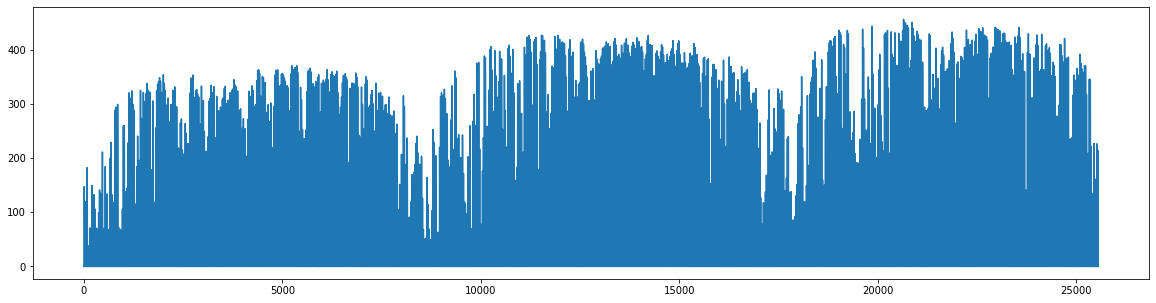

In [51]:
plt.figure(figsize=(20,5))
plt.plot(df['Generation'])
plt.show()

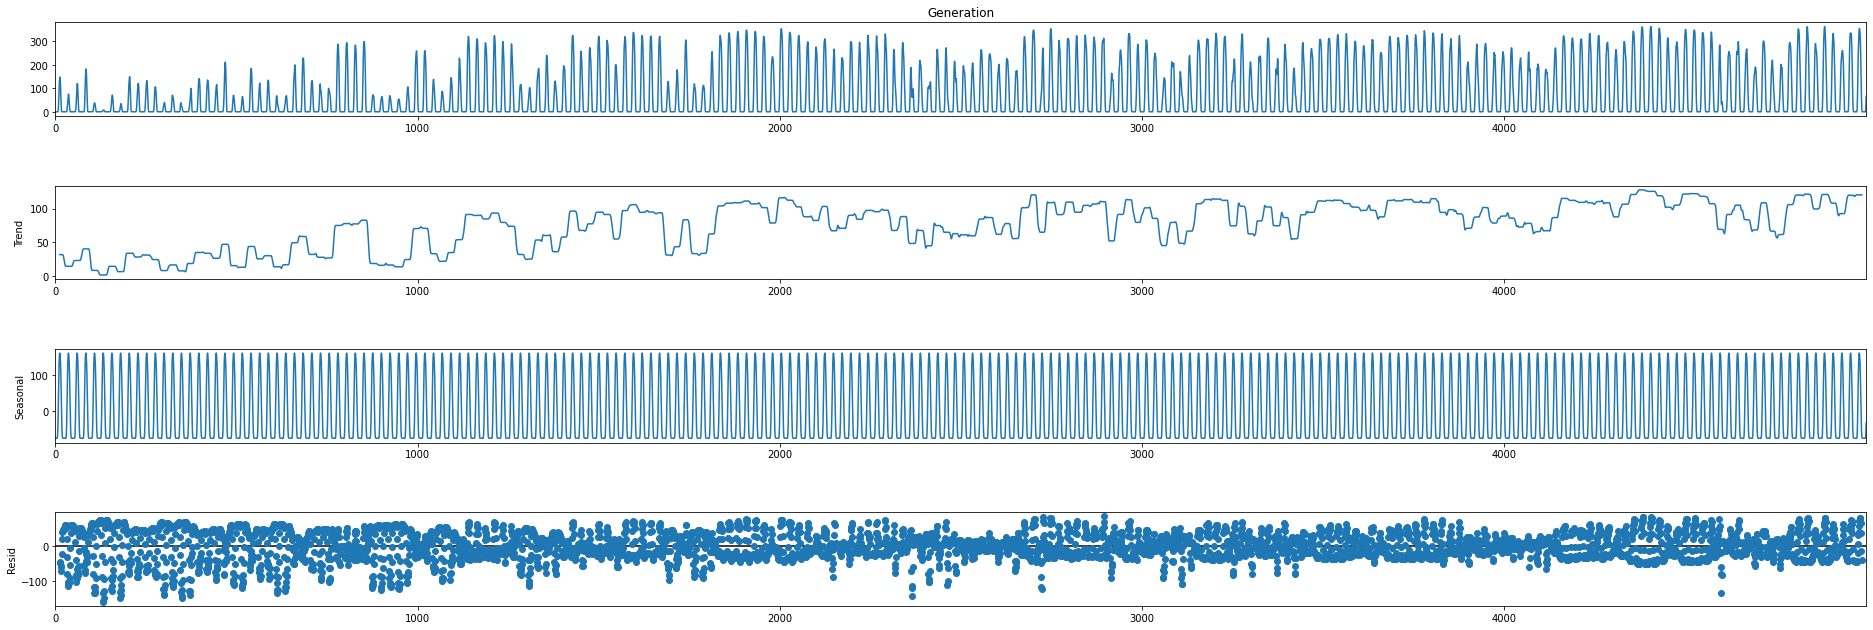

In [52]:
decomposition = sm.tsa.seasonal_decompose(df["Generation"][:5000], period=24)
fig = decomposition.plot()
fig.set_figwidth(30)
fig.set_figheight(10)

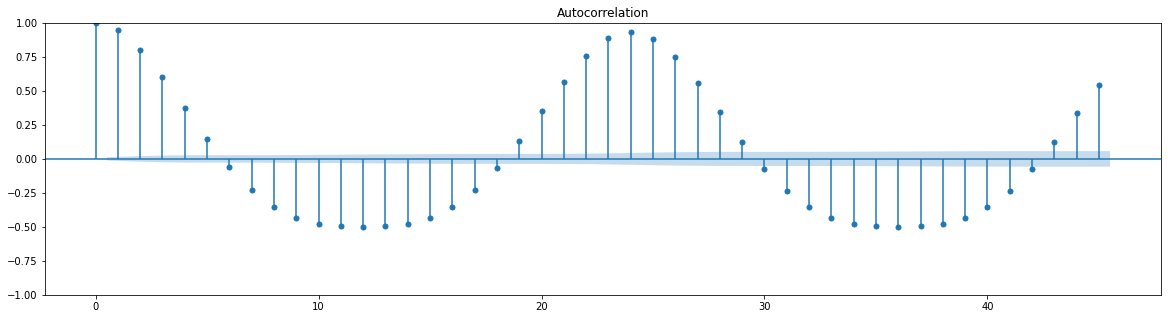

In [53]:
fig = plot_acf(df['Generation'])
fig.set_figwidth(20)
fig.set_figheight(5)

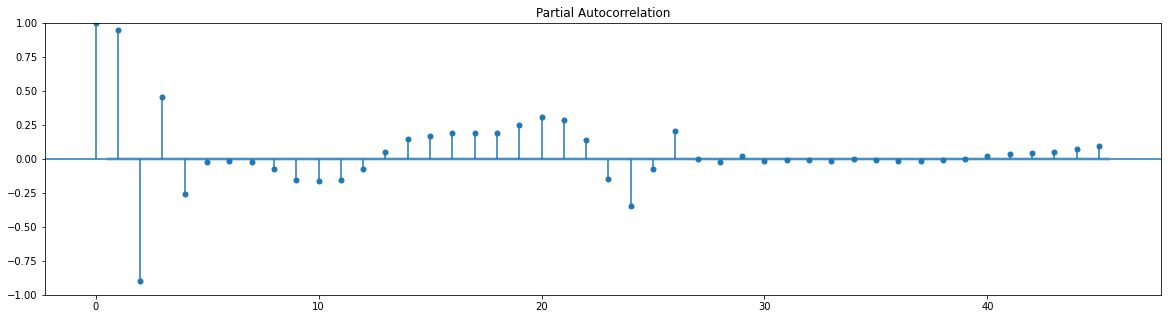

In [54]:
fig = plot_pacf(df['Generation'])
fig.set_figwidth(20)
fig.set_figheight(5)

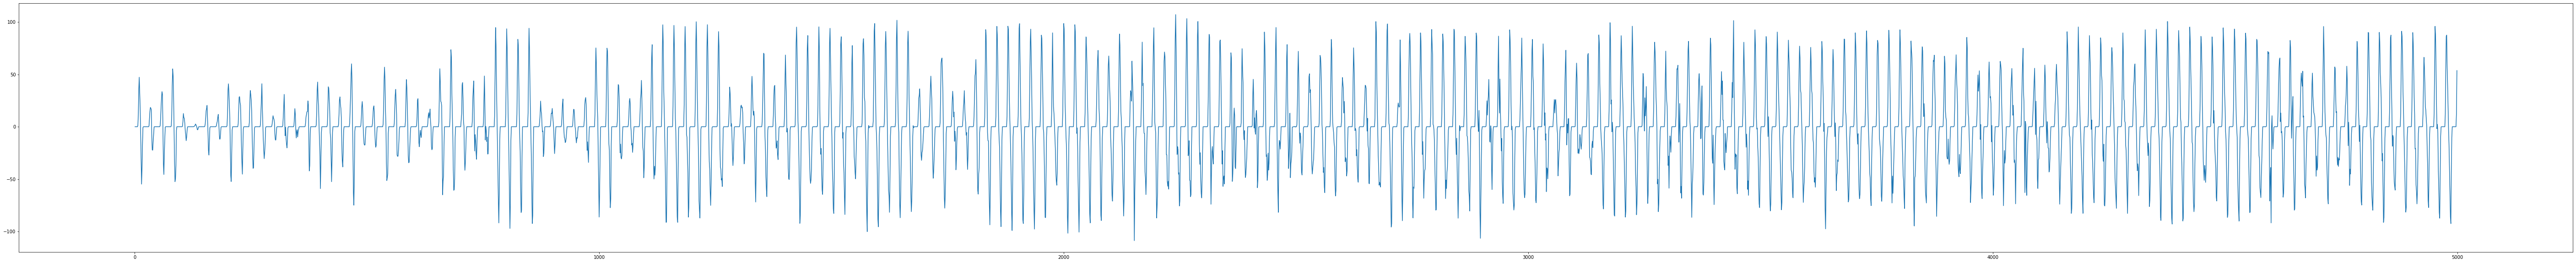

In [55]:
diff = df['Generation'].diff()
plt.figure(figsize=(100,10))
diff[:5000].plot()
plt.show()

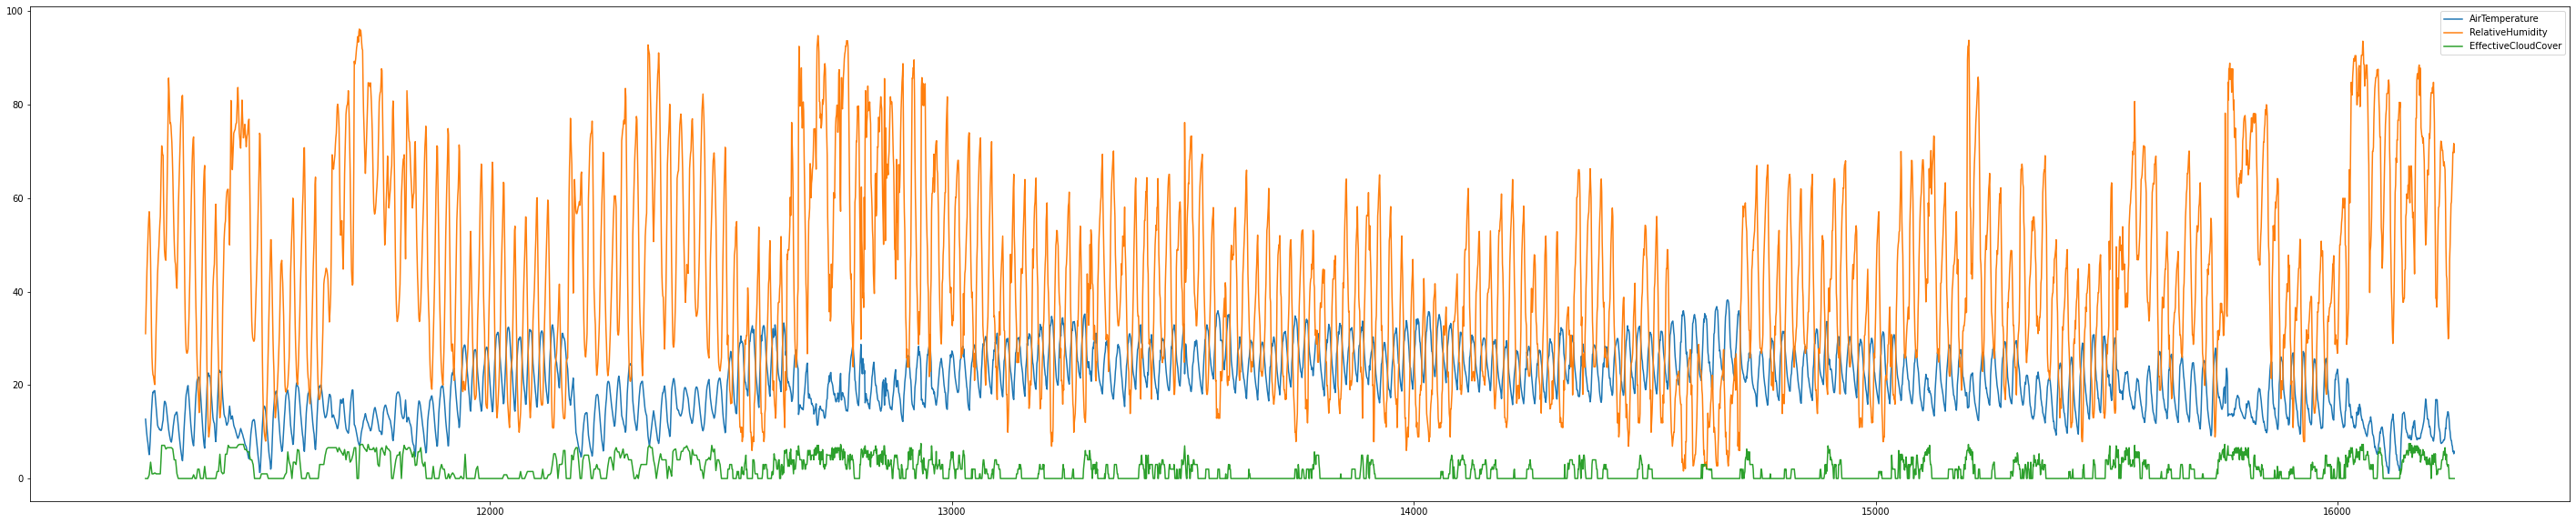

In [56]:
plt.figure(figsize=(50,10))
temp_df['AirTemperature'][5000:10000].plot()
temp_df['RelativeHumidity'][5000:10000].plot()
temp_df['EffectiveCloudCover'][5000:10000].plot()
plt.legend(['AirTemperature', 'RelativeHumidity', 'EffectiveCloudCover'])
plt.show()

In [61]:
X.head(10)

AirTemperature                                                  \
DateTime               0           1           2           3           4    
date                                                                        
2020-01-01     4.10000000  4.20000000  4.30000000  4.10000000  3.70000000   
2020-01-02     2.00000000  1.60000000  1.30000000  1.20000000  1.40000000   
2020-01-03     0.30000000  0.70000000  0.70000000  0.60000000 -0.10000000   
2020-01-04    -1.30000000 -0.40000000  0.00000000 -1.30000000 -1.80000000   
2020-01-05     1.20000000  1.30000000  1.20000000  0.90000000  0.50000000   
2020-01-06     1.70000000  1.70000000  1.10000000  1.60000000  1.50000000   
2020-01-07     1.90000000  2.40000000  2.60000000  3.40000000  4.00000000   
2020-01-08     3.60000000  3.60000000  3.40000000  3.30000000  3.50000000   
2020-01-09     1.20000000  1.30000000  1.00000000  0.90000000  0.90000000   
2020-01-10    -1.60000000 -2.40000000 -3.10000000 -3.50000000 -4.10000000   

                                                                        ...  \
DateTime            5           6           7           8           9   ...   
date                                                                    ...   
2020-01-01  3.60000000  3.50000000  3.20000000  3.30000000  3.30000000  ...   
2020-01-02  1.00000000  1.20000000  0.80000000  0.70000000  0.80000000  ...   
2020-01-03 -0.50000000 -0.70000000 -0.50000000 -0.50000000  0.60000000  ...   
2020-01-04 -1.60000000 -1.50000000 -1.60000000 -1.30000000 -1.00000000  ...   
2020-01-05  0.60000000  0.00000000 -1.10000000 -1.20000000 -1.00000000  ...   
2020-01-06  1.30000000  1.50000000  1.50000000  1.70000000  1.30000000  ...   
2020-01-07  3.60000000  3.70000000  3.40000000  3.70000000  4.60000000  ...   
2020-01-08  3.60000000  3.60000000  3.60000000  3.30000000  3.50000000  ...   
2020-01-09  0.60000000  0.20000000  0.30000000  0.00000000 -0.20000000  ...   
2020-01-10 -4.40000000 -4.70000000 -4.90000000 -5.10000000 -4.20000000  ...   

            month_cos                                                         \
DateTime           14         15         16         17         18         19   
date                                                                           
2020-01-01 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-02 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-03 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-04 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-05 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-06 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-07 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-08 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-09 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   
2020-01-10 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540 0.86602540   

                                                        
DateTime           20         21         22         23  
date                                                    
2020-01-01 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-02 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-03 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-04 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-05 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-06 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-07 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-08 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-09 0.86602540 0.86602540 0.86602540 0.86602540  
2020-01-10 0.86602540 0.86602540 0.86602540 0.86602540  

[10 rows x 480 columns]

In [62]:
y.head()

Generation                                                         \
DateTime           0          1          2          3          4          5    
date                                                                           
2020-01-01 0.00000800 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000   
2020-01-02 0.00000800 0.00000000 0.00000000 0.00000000 0.00000000 0.00000800   
2020-01-03 0.00000000 0.00000800 0.00000000 0.00000000 0.00000800 0.00000000   
2020-01-04 0.00000800 0.00000000 0.00000000 0.00000800 0.00000000 0.00000000   
2020-01-05 0.00000800 0.00000000 0.00000000 0.00000800 0.00000000 0.00000000   

                                                           ...               \
DateTime           6          7           8            9   ...           14   
date                                                       ...                
2020-01-01 0.00000800 1.40400980 11.52959320  44.99627460  ...  54.90760730   
2020-01-02 0.00000000 0.66767860 12.22673490  67.11848880  ... 152.08776300   
2020-01-03 0.00000000 3.61156860 34.96674690 112.04218110  ... 178.50965700   
2020-01-04 0.00000800 1.14947680 13.66138750  49.03790470  ... 101.72319030   
2020-01-05 0.00000800 5.23145890 38.73596810 109.15563830  ...  93.72088480   

                                                                      \
DateTime             15          16         17         18         19   
date                                                                   
2020-01-01  36.38783180 11.35703300 0.49289670 0.00000800 0.00000000   
2020-01-02  98.41757670 37.40218110 2.55777450 0.00000000 0.00000000   
2020-01-03 106.83444310 42.44541300 3.55570580 0.00000000 0.00000800   
2020-01-04  60.69427120 19.35255100 0.96896130 0.00000000 0.00000800   
2020-01-05  48.19202580 17.34538750 1.58714210 0.00286300 0.00000000   

                                                        
DateTime           20         21         22         23  
date                                                    
2020-01-01 0.00000000 0.00000800 0.00000000 0.00000000  
2020-01-02 0.00000800 0.00000000 0.00000000 0.00000800  
2020-01-03 0.00000000 0.00000800 0.00000000 0.00000000  
2020-01-04 0.00000000 0.00000800 0.00000000 0.00000000  
2020-01-05 0.00000800 0.00000000 0.00000000 0.00000800  

[5 rows x 24 columns]

In [63]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=1480, random_state = 1)

# Model

In [60]:
#K-Fold 
kf = KFold(n_splits=10, shuffle=True, random_state=1)
score_list = []
test_preds = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse_score = np.sqrt(mean_squared_error(y_val, y_pred))
    score_list.append(rmse_score)
    y_test = model.predict(X_test)
    test_preds.append(y_test)

print(score_list)
print("RMSE Score: ", np.mean(score_list))

[19.208695548323043, 17.180674229068444, 18.587505112671273, 16.968622906777775, 18.724572661057096, 21.151095033045987, 17.841141170573884, 18.09012996842809, 17.114132040006833, 20.219079880573865]
RMSE Score:  18.50856485505263


# Submission

In [15]:
#Submission
y_sub = np.mean(test_preds, axis=0)
y_sub = pd.DataFrame(y_sub)
y_sub['DateTime'] = np.unique(pd.to_datetime(test_df.DateTime).dt.date)
y_sub = y_sub.melt(id_vars=['DateTime']).sort_values(by=['DateTime', 'variable'])
y_sub.value = y_sub.value.apply(lambda x: 0 if x<0 else x)
y_sub.DateTime = test_df.DateTime.values
y_sub.drop('variable', axis=1, inplace=True)
y_sub.columns = ['DateTime', 'Generation']
y_sub.to_csv('submission.csv', index=False)